In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Contrasting

# Generate a list of contrast adjusted images

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

contrast_factor = 0.3 # 0 gray - 1 original image - 2 increases the contrast by a factor of 2.

def apply_contrast(images, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images]
    images = torch.stack(images_list)
    contrast_adjusted_images = F.adjust_contrast(images, contrast_factor)
    return contrast_adjusted_images 

train_contrasted_images = apply_contrast(train_dataset.data, contrast_factor)
test_contrasted_images = apply_contrast(test_dataset.data, contrast_factor)

train_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in train_contrasted_images]))
test_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in test_contrasted_images]))
print("Train contrast adjusted images shape")
print(train_contrasted_images.shape)

print("Test contrast adjusted images shape")
print(test_contrasted_images.shape)



Train contrast adjusted images shape
(50000, 32, 32, 3)
Test contrast adjusted images shape
(10000, 32, 32, 3)


# Visualizing generated contrast adjusted images

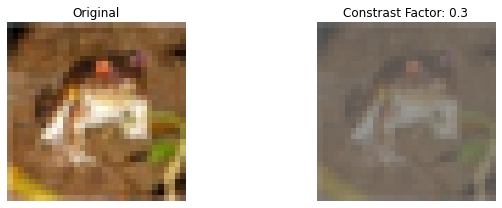

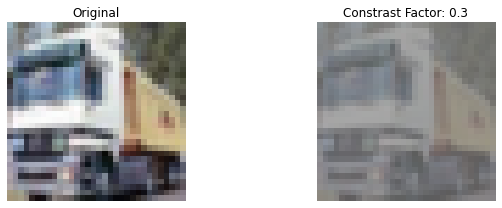

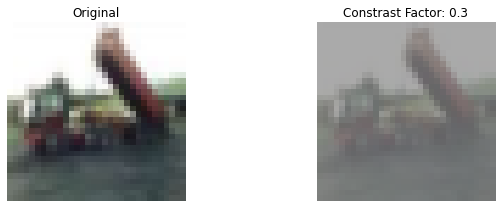

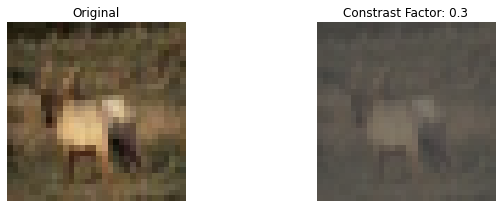

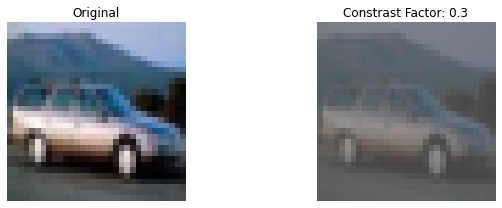

In [4]:
i=0
for constrasted_image in train_contrasted_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(constrasted_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Constrast Factor: "+str(contrast_factor))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and contrasted images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
contrasted_image_labels = np.ones(len(train_contrasted_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_contrasted_image_labels = np.ones(len(test_contrasted_images))

train_original_and_contrasted_images = np.concatenate((train_dataset.data, train_contrasted_images), axis=0)
train_contrast_labels = np.concatenate((original_image_labels, contrasted_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_contrasted_images = np.concatenate((test_dataset.data, test_contrasted_images), axis=0)
test_contrast_labels = np.concatenate((test_original_image_labels, test_contrasted_image_labels), axis=None)


print("Combined contrasted and original train images shape")
print(train_original_and_contrasted_images.shape)


Combined contrasted and original train images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec()

Z = img2vec.get_vec(train_original_and_contrasted_images)

Z_test = img2vec.get_vec(test_original_and_contrasted_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_contrasted = img2vec.get_vec(test_contrasted_images)

# vec.shape
print("Shape of extracted features for combined contrasted and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for contrasted test images")
print(Z_test_contrasted.shape)


Shape of extracted features for combined contrasted and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for contrasted test images
(10000, 512)


# Obtaining contrast prediction coefficients

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_contrast_labels)

contrast_coefficients = lr_model.coef_.reshape(-1,1)
contrast_coefficients = contrast_coefficients / np.linalg.norm(contrast_coefficients)

print("Contrast coefficients shape")
print(contrast_coefficients.shape)

print('Contrast prediction accuracy on training data: ', lr_model.score(Z, train_contrast_labels))

print('Contrast prediction accuracy on test data-rotaed and original combined: ', lr_model.score(Z_test, test_contrast_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Contrast coefficients shape
(512, 1)
Contrast prediction accuracy on training data:  0.99631
Contrast prediction accuracy on test data-rotaed and original combined:  0.9939


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Trained on original extracted image features Z, tested on contrasted extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


targets_train = np.array(test_dataset.targets)
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_test_original, targets_train)

print('LR Accuracy within training data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_train))
print('LR Accuracy on test data - Z contrasted features: ', logistic_regression_model.score(Z_test_contrasted, targets_test))



LR Accuracy within training data - Z original features:  0.7486
LR Accuracy on test data - Z contrasted features:  0.3866


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions





Results for lamda  1

Printing eigenvalues
(512,)
[-6.36681398e+01 -1.53570470e+01 -1.43274679e+01 -7.97922523e+00
 -6.21715202e+00 -5.55154496e+00 -5.12707925e+00 -4.42268621e+00
 -4.11253431e+00 -3.15400898e+00 -2.76267350e+00 -2.53887261e+00
 -2.26277194e+00 -2.11192506e+00 -1.96987865e+00 -1.79943002e+00
 -1.62941063e+00 -1.45224687e+00 -1.37810034e+00 -1.23736619e+00
 -1.12356084e+00 -1.05843906e+00 -1.03090290e+00 -9.72622591e-01
 -8.58492152e-01 -8.35367699e-01 -8.04900384e-01 -6.81320789e-01
 -6.57308681e-01 -6.28375774e-01 -6.22412335e-01 -5.82114079e-01
 -5.41029128e-01 -5.03999391e-01 -4.80678650e-01 -4.59435819e-01
 -4.46383711e-01 -4.20869276e-01 -4.05639289e-01 -3.82324823e-01
 -3.76831261e-01 -3.52125317e-01 -3.49291926e-01 -3.22656503e-01
 -2.97320263e-01 -2.80018907e-01 -2.73100373e-01 -2.68977125e-01
 -2.64660058e-01 -2.53783346e-01 -2.49506472e-01 -2.39799478e-01
 -2.28847896e-01 -2.20638905e-01 -2.13365821e-01 -2.11397789e-01
 -1.96151495e-01 -1.91343709e-01 -1.

(512, 512)

array([[-0.03401662, -0.00156685,  0.00285736, ...,  0.01995224,
        -0.0109566 , -0.0100487 ],
       [-0.05857318, -0.05229081, -0.1465557 , ...,  0.05984758,
        -0.02010243, -0.01625299],
       [-0.01559159, -0.00771963, -0.04050005, ...,  0.00716445,
        -0.00221662, -0.0132035 ],
       ...,
       [-0.05444446, -0.11697071,  0.09641355, ..., -0.00221482,
        -0.06205519, -0.15250479],
       [-0.04962961, -0.07325242, -0.02637995, ..., -0.00511518,
        -0.01725581, -0.00190061],
       [ 0.00139003,  0.00198031, -0.00031013, ..., -0.01302435,
         0.00047224, -0.01756688]])

Printing least k eigenvalues before removing the zero eigenvalue
[-63.66813982 -15.35704703 -14.32746788  -7.97922523  -6.21715202
  -5.55154496  -5.12707925  -4.42268621  -4.11253431  -3.15400898
  -2.7626735   -2.53887261  -2.26277194  -2.11192506  -1.96987865
  -1.79943002  -1.62941063  -1.45224687  -1.37810034  -1.23736619
  -1.12356084  -1.05843906  -1.0309029   -0.97262259  -0.85849215]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-63.66813982 -15.35704703 -14.32746788  -7.97922523  -6.21715202
  -5.55154496  -5.12707925  -4.42268621  -4.11253431  -3.15400898
  -2.7626735   -2.53887261  -2.26277194  -2.11192506  -1.96987865
  -1.79943002  -1.62941063  -1.45224687  -1.37810034  -1.23736619
  -1.12356084  -1.05843906  -1.0309029   -0.97262259]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.332889,6.342548,8.744972,0.850563,2.207232,3.126926,0.711760,2.225434,1.876899,...,1.404237,0.517177,1.216244,0.201583,0.732503,0.019869,0.136508,2.396580,1.561760,0.075830
1,3.200015,0.051161,3.974558,9.302931,0.249761,5.442155,1.253758,3.333908,1.322292,1.063188,...,2.046908,3.342998,1.200281,0.425174,0.871649,2.267687,1.854389,2.280190,1.087782,1.027645
2,3.194737,1.853600,2.758868,8.335392,1.431437,2.455910,2.243315,1.367524,1.811092,1.703053,...,1.192207,0.659460,0.620460,0.238364,0.917001,0.706443,1.254787,0.753169,0.102126,0.606318
3,1.697847,1.558607,1.126395,5.413456,2.047733,3.001377,0.534178,0.692186,0.178158,0.797396,...,1.957394,1.634327,1.090166,0.782279,0.287939,0.334092,0.950107,0.841409,0.447795,1.650953
4,1.591675,0.509928,8.174517,3.103161,1.951841,3.873729,0.753878,0.303710,2.292575,1.303133,...,0.146402,0.023018,1.456695,0.723834,0.543313,2.019348,1.360471,0.256575,2.307544,0.975896


Histogram for F Test feature  0


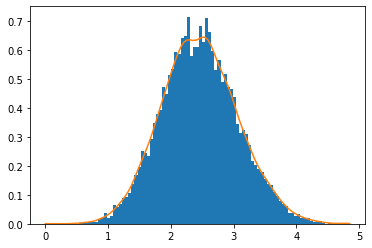

Histogram for F Test feature  1


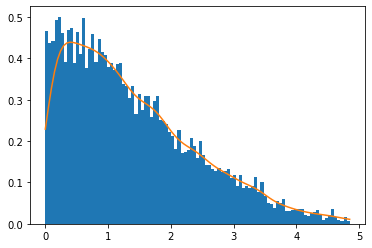

Histogram for F Test feature  2


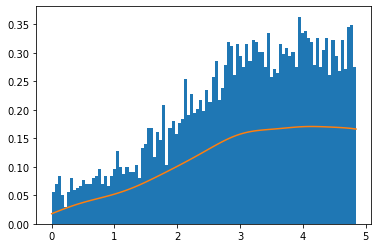

Histogram for F Test feature  3


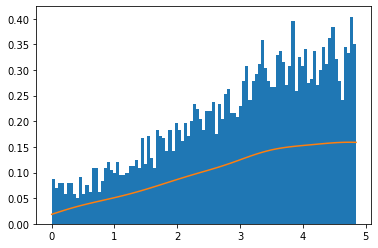

Histogram for F Test feature  4


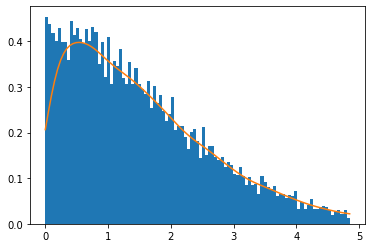

Histogram for F Test feature  5


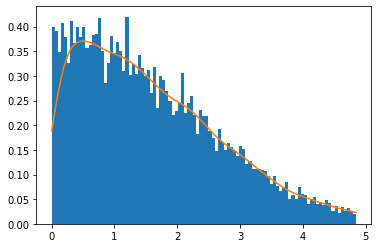

Histogram for F Test feature  6


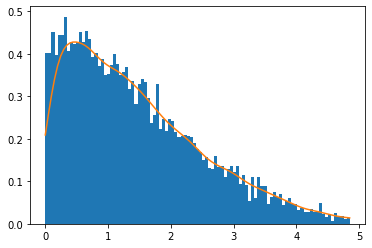

Histogram for F Test feature  7


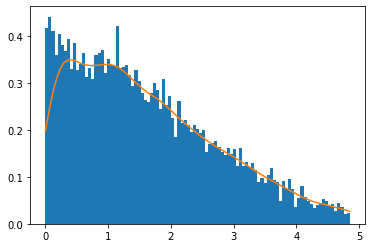

Histogram for F Test feature  8


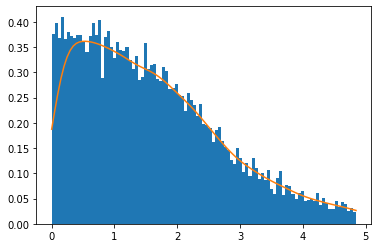

Histogram for F Test feature  9


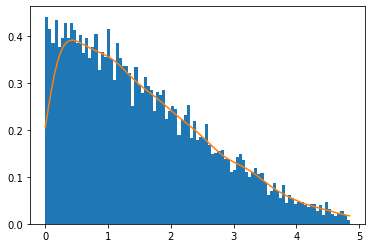

Histogram for F Test feature  10


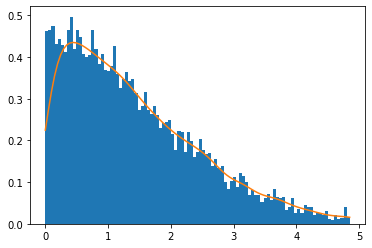

Histogram for F Test feature  11


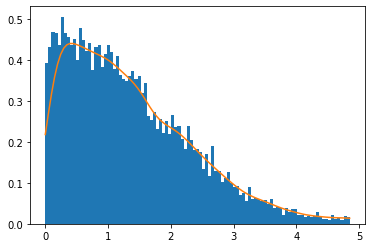

Histogram for F Test feature  12


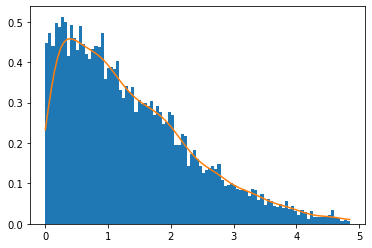

Histogram for F Test feature  13


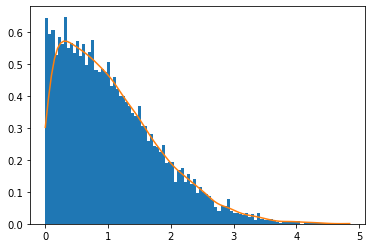

Histogram for F Test feature  14


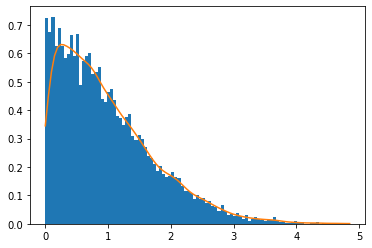

Histogram for F Test feature  15


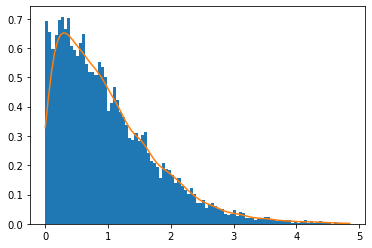

Histogram for F Test feature  16


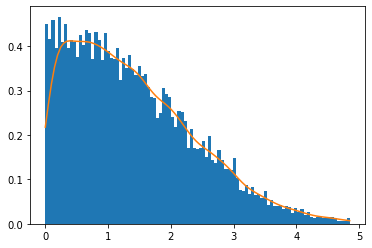

Histogram for F Test feature  17


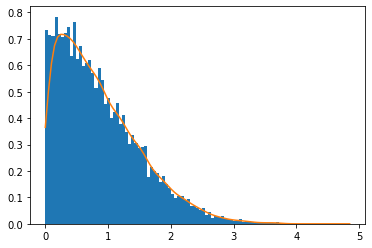

Histogram for F Test feature  18


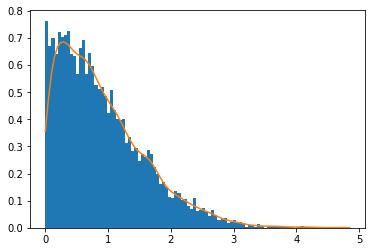

Histogram for F Test feature  19


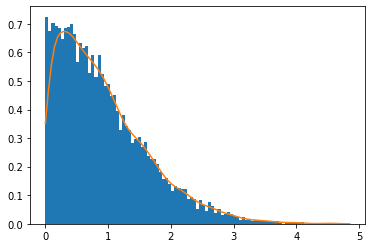

Histogram for F Test feature  20


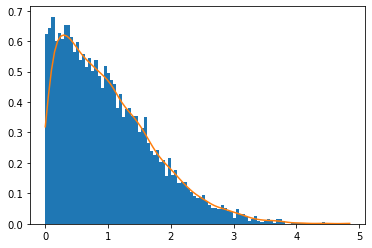

Histogram for F Test feature  21


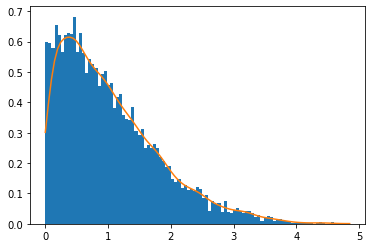

Histogram for F Test feature  22


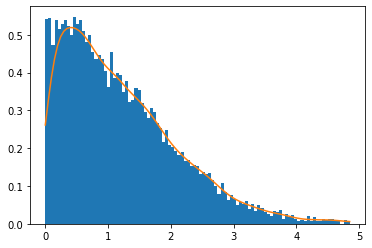

Histogram for F Test feature  23


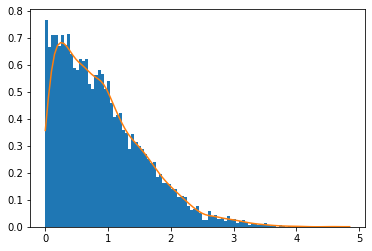

Histogram for F Test feature  24


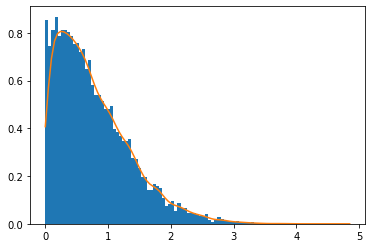

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.555
LR Accuracy on test data - All features:  0.2745
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5569
Logistic Regression Accuracy on test data - contrasted:  0.2944
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5547
Logistic Regression Accuracy on test data - contrasted:  0.2708
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5413
Logistic Regression Accuracy on test data - contrasted:  0.2612
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5421
Logistic Regression Accuracy on test data - contrasted:  0.2912
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5373
Logistic Regression Accuracy on test data - contrasted:  0.2533
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5412
Logistic Regression Accuracy on test data - contrasted:  0.2472
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5434
Logistic Regression Accuracy on test data - contrasted:  0.2585
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5493
Logistic Regression Accuracy on test data - contrasted:  0.2743
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5457
Logistic Regression Accuracy on test data - contrasted:  0.2714
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5428
Logistic Regression Accuracy on test data - contrasted:  0.2664
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5501
Logistic Regression Accuracy on test data - contrasted:  0.2768
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.541
Logistic Regression Accuracy on test data - contrasted:  0.2592
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5449
Logistic Regression Accuracy on test data - contrasted:  0.2737
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5512
Logistic Regression Accuracy on test data - contrasted:  0.2787
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5495
Logistic Regression Accuracy on test data - contrasted:  0.2689
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5436
Logistic Regression Accuracy on test data - contrasted:  0.2718
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.551
Logistic Regression Accuracy on test data - contrasted:  0.2721
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5552
Logistic Regression Accuracy on test data - contrasted:  0.2732
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5492
Logistic Regression Accuracy on test data - contrasted:  0.2731
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5519
Logistic Regression Accuracy on test data - contrasted:  0.269
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5543
Logistic Regression Accuracy on test data - contrasted:  0.2762
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5501
Logistic Regression Accuracy on test data - contrasted:  0.2752
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5515
Logistic Regression Accuracy on test data - contrasted:  0.2868
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5558
Logistic Regression Accuracy on test data - contrasted:  0.2729
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5529
Logistic Regression Accuracy on test data - contrasted:  0.2706




Results for lamda  10

Printing eigenvalues
(512,)
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
 -1.59171964e-08  9.81357514e-03  3.39970881e-02  4.70490262e-02
  5.68856212e-02  6.49879560e-02  7.09833386e-02  9.42729747e-02
  9.75727114e-02  9.86121484e-02  1.02455477e-01  1.04905247e-01
  1.06228651e-01  1.15778716e-01  1.16612290e-01  1.27723823e-01
  1.30912908e-01  1.32619459e-01  1.37994609e-01  1.38587839e-01
  1.40259965e-01  1.44444835e-01  1.46532400e-01  1.47288875e-01
  1.50808708e-01  1.55304683e-01  1.56777103e-01  1.60936653e-01
  1.65603692e-01  1.66982966e-01  1.68730972e-01  1.70625932e-01
  1.72804717e-01  1.74555149e-01  1.76310788e-01  1.79410570e-01
  1.81046741e-01  1.82227

(512, 512)

array([[ 0.02352554,  0.00590326, -0.01704888, ..., -0.00296228,
         0.01073742,  0.03222864],
       [-0.00030737,  0.05912283,  0.10282429, ...,  0.15720795,
         0.06861949,  0.06010652],
       [-0.01505348,  0.02416324,  0.00727166, ...,  0.03237763,
         0.01751009,  0.024493  ],
       ...,
       [ 0.07303601, -0.14277637, -0.03413231, ...,  0.01374384,
         0.03604427,  0.11189599],
       [ 0.04246947, -0.03330289,  0.06702557, ...,  0.01396857,
         0.01932149,  0.02352684],
       [-0.00131071, -0.01618659,  0.00597991, ..., -0.01219568,
         0.00378032,  0.01320478]])

Printing least k eigenvalues before removing the zero eigenvalue
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
  0.00000000e+00  9.81357514e-03  3.39970881e-02  4.70490262e-02
  5.68856212e-02  6.49879560e-02  7.09833386e-02  9.42729747e-02
  9.75727114e-02  9.86121484e-02  1.02455477e-01  1.04905247e-01
  1.06228651e-01]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
  9.81357514e-03  3.39970881e-02  4.70490262e-02  5.68856212e-02
  6.49879560e-02  7.09833386e-02  9.42729747e-02  9.75727114e-02
  9.86121484e-02  1.02455477e-01  1.04905247e-01  1.06228651e-01]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021977,5.898528,7.305259,0.856361,0.030982,0.222429,1.462793,2.789165,0.080638,2.271797,...,0.040147,0.041191,0.151553,0.125423,0.229806,0.269116,0.313401,0.233715,0.297576,0.483207
1,3.200015,5.596352,7.093625,0.170426,0.925632,2.723973,0.481864,1.462515,1.098701,1.754391,...,0.014163,0.094356,0.037794,0.130134,0.572280,0.087425,0.025121,0.161564,0.152441,0.231012
2,3.194731,3.933674,6.998993,1.591995,0.459836,0.868184,1.167574,0.404010,1.729205,0.857031,...,0.075286,0.075298,0.141236,0.456406,0.259967,0.008920,0.005784,0.004336,0.055329,0.022633
3,1.697844,1.243282,3.845387,0.715376,1.276663,1.822857,0.036087,1.046257,0.960205,1.265750,...,0.031994,0.018354,0.060924,0.076013,0.335455,0.131145,0.127202,0.066072,0.290416,0.321353
4,1.591671,3.156290,6.091927,1.384743,0.995208,2.267274,0.611373,0.118003,1.243968,1.379613,...,0.134744,0.477641,0.067661,0.635392,0.271798,0.038514,0.096983,0.222028,0.223626,0.156143


Histogram for F Test feature  0


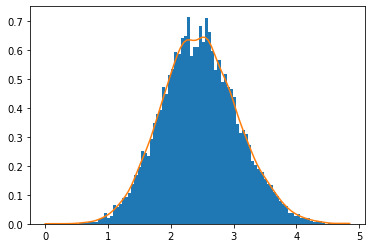

Histogram for F Test feature  1


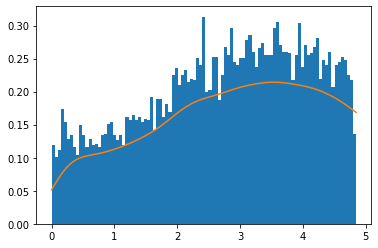

Histogram for F Test feature  2


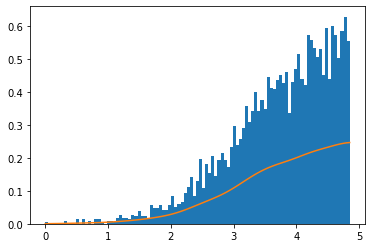

Histogram for F Test feature  3


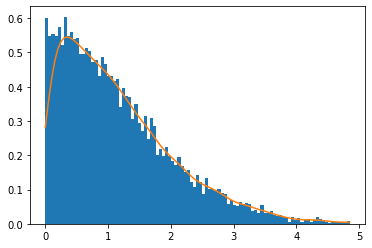

Histogram for F Test feature  4


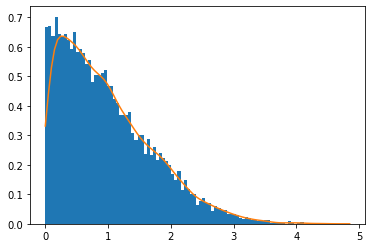

Histogram for F Test feature  5


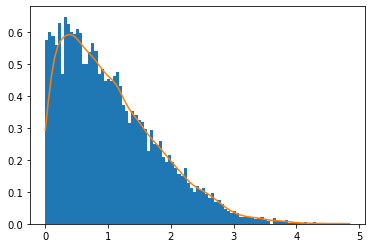

Histogram for F Test feature  6


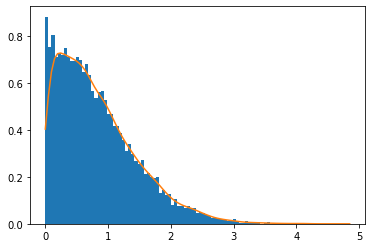

Histogram for F Test feature  7


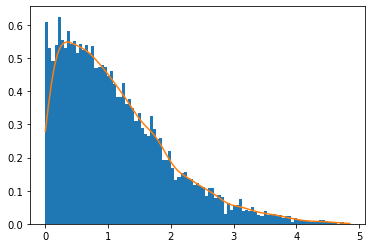

Histogram for F Test feature  8


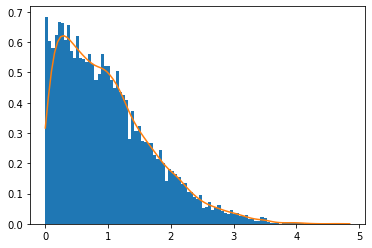

Histogram for F Test feature  9


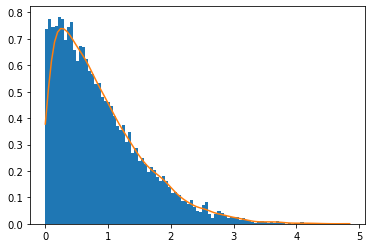

Histogram for F Test feature  10


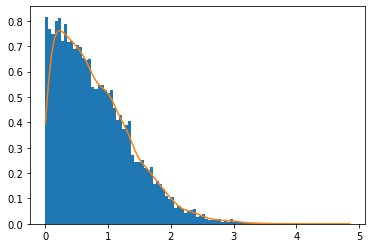

Histogram for F Test feature  11


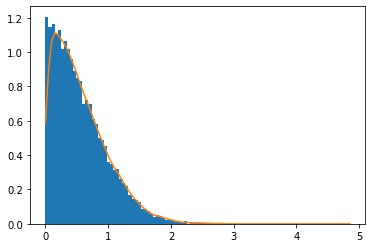

Histogram for F Test feature  12


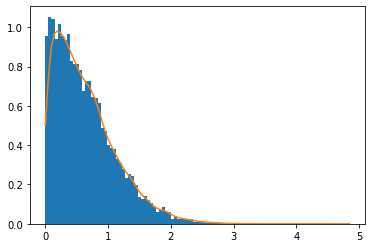

Histogram for F Test feature  13


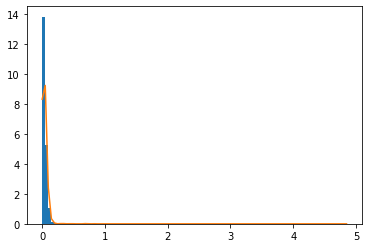

Histogram for F Test feature  14


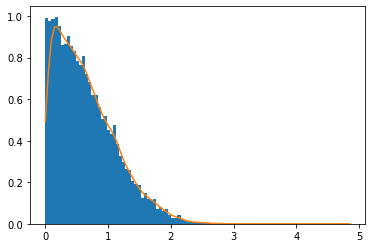

Histogram for F Test feature  15


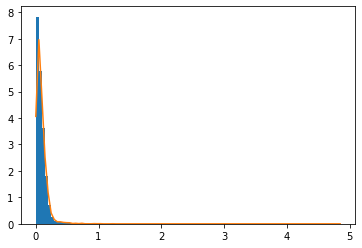

Histogram for F Test feature  16


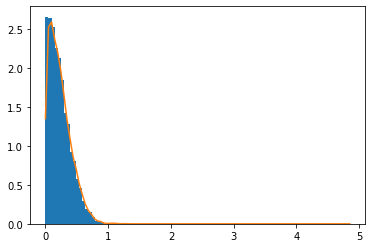

Histogram for F Test feature  17


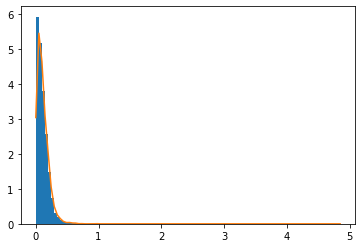

Histogram for F Test feature  18


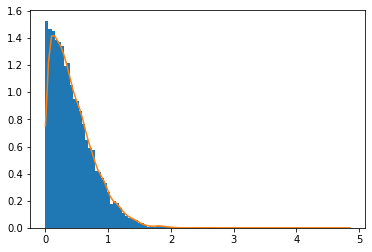

Histogram for F Test feature  19


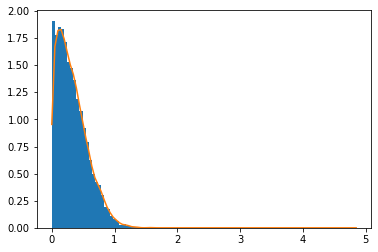

Histogram for F Test feature  20


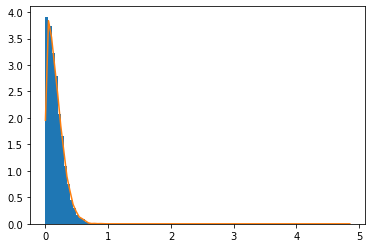

Histogram for F Test feature  21


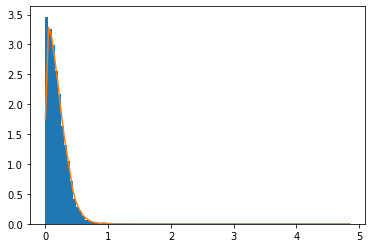

Histogram for F Test feature  22


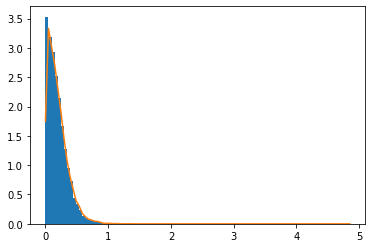

Histogram for F Test feature  23


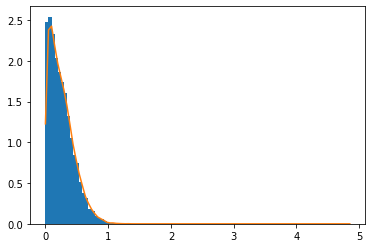

Histogram for F Test feature  24


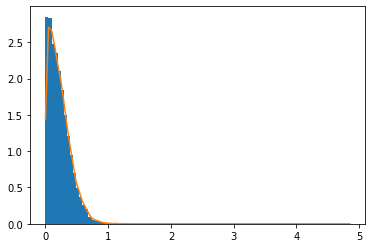

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5244
LR Accuracy on test data - All features:  0.2927
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5222
Logistic Regression Accuracy on test data - contrasted:  0.3064
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5197
Logistic Regression Accuracy on test data - contrasted:  0.285
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5156
Logistic Regression Accuracy on test data - contrasted:  0.3077
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.4794
Logistic Regression Accuracy on test data - contrasted:  0.2316
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5104
Logistic Regression Accuracy on test data - contrasted:  0.2852
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.516
Logistic Regression Accuracy on test data - contrasted:  0.2745
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5082
Logistic Regression Accuracy on test data - contrasted:  0.2841
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5184
Logistic Regression Accuracy on test data - contrasted:  0.2809
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.4989
Logistic Regression Accuracy on test data - contrasted:  0.2718
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5167
Logistic Regression Accuracy on test data - contrasted:  0.2905
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5148
Logistic Regression Accuracy on test data - contrasted:  0.2786
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5155
Logistic Regression Accuracy on test data - contrasted:  0.2875
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5181
Logistic Regression Accuracy on test data - contrasted:  0.28
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5243
Logistic Regression Accuracy on test data - contrasted:  0.2928
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5214
Logistic Regression Accuracy on test data - contrasted:  0.292
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5228
Logistic Regression Accuracy on test data - contrasted:  0.2906
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5224
Logistic Regression Accuracy on test data - contrasted:  0.2918
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5242
Logistic Regression Accuracy on test data - contrasted:  0.2911
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5196
Logistic Regression Accuracy on test data - contrasted:  0.2905
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5189
Logistic Regression Accuracy on test data - contrasted:  0.2909
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5227
Logistic Regression Accuracy on test data - contrasted:  0.2922
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5218
Logistic Regression Accuracy on test data - contrasted:  0.2911
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5197
Logistic Regression Accuracy on test data - contrasted:  0.2932
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5188
Logistic Regression Accuracy on test data - contrasted:  0.2895
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5213
Logistic Regression Accuracy on test data - contrasted:  0.2944




Results for lamda  100

Printing eigenvalues
(512,)
[-3.77911285e-07  8.87978569e-02  1.14635855e-01  5.29098079e-01
  6.38158564e-01  6.95792438e-01  1.04373022e+00  1.08125926e+00
  1.12432954e+00  1.15077804e+00  1.19297040e+00  1.23082300e+00
  1.31110373e+00  1.41881436e+00  1.44115209e+00  1.48757069e+00
  1.50194931e+00  1.53004133e+00  1.55863409e+00  1.59044052e+00
  1.62952905e+00  1.65949407e+00  1.70452004e+00  1.71302243e+00
  1.77118905e+00  1.80215979e+00  1.82452228e+00  1.87030787e+00
  1.88753865e+00  1.90886338e+00  1.93771304e+00  1.96141967e+00
  1.98248754e+00  2.00718930e+00  2.02113400e+00  2.04947470e+00
  2.05685811e+00  2.07762975e+00  2.09606386e+00  2.10471434e+00
  2.11884098e+00  2.14337562e+00  2.16034065e+00  2.20239972e+00
  2.20895077e+00  2.23430575e+00  2.25518887e+00  2.27634026e+00
  2.30339902e+00  2.3269

(512, 512)

array([[ 0.05036701, -0.01172007,  0.01217786, ..., -0.00439387,
         0.01054262,  0.0330226 ],
       [-0.04326324,  0.00052468, -0.00246803, ...,  0.16345768,
         0.07765171,  0.06157722],
       [ 0.03405628,  0.02111145, -0.01803626, ...,  0.03425078,
         0.01997943,  0.02461635],
       ...,
       [ 0.01851719,  0.00887463, -0.00904156, ...,  0.01443736,
         0.03596645,  0.10913649],
       [-0.10363955, -0.00879092,  0.00924883, ...,  0.01913009,
         0.02112485,  0.02518625],
       [-0.02056375, -0.02889119,  0.00471769, ..., -0.0124428 ,
         0.00400319,  0.01259542]])

Printing least k eigenvalues before removing the zero eigenvalue
[0.         0.08879786 0.11463585 0.52909808 0.63815856 0.69579244
 1.04373022 1.08125926 1.12432954 1.15077804 1.1929704  1.230823
 1.31110373 1.41881436 1.44115209 1.48757069 1.50194931 1.53004133
 1.55863409 1.59044052 1.62952905 1.65949407 1.70452004 1.71302243
 1.77118905]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[0.08879786 0.11463585 0.52909808 0.63815856 0.69579244 1.04373022
 1.08125926 1.12432954 1.15077804 1.1929704  1.230823   1.31110373
 1.41881436 1.44115209 1.48757069 1.50194931 1.53004133 1.55863409
 1.59044052 1.62952905 1.65949407 1.70452004 1.71302243 1.77118905]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021985,1.353964,1.278941,0.052438,0.031109,0.144883,0.075835,0.031583,0.124823,0.052295,...,0.063713,0.254441,0.017548,0.087832,0.049051,0.035824,0.045079,0.039270,0.096055,0.119582
1,3.200029,1.305381,1.208806,0.016388,0.138733,0.119425,0.033325,0.041926,0.009480,0.023003,...,0.214857,0.154613,0.136668,0.142766,0.027987,0.164519,0.075613,0.264293,0.300511,0.208900
2,3.194747,1.006405,0.959900,0.014766,0.046207,0.141370,0.062519,0.062019,0.062421,0.056012,...,0.160214,0.045248,0.033810,0.166587,0.104858,0.052527,0.096785,0.090918,0.218592,0.091909
3,1.697852,0.436562,0.412094,0.039878,0.025279,0.035171,0.031380,0.074567,0.024392,0.110264,...,0.121161,0.060054,0.033796,0.093717,0.005754,0.310280,0.297007,0.101145,0.025668,0.037837
4,1.591682,0.661462,0.639624,0.018490,0.097346,0.082689,0.203049,0.156209,0.057227,0.058837,...,0.213345,0.007317,0.320040,0.093923,0.062640,0.040433,0.013300,0.017643,0.208920,0.291057


Histogram for F Test feature  0


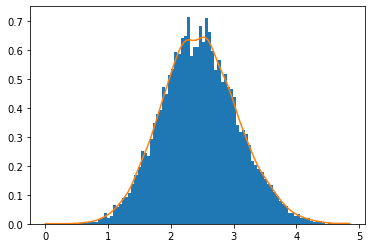

Histogram for F Test feature  1


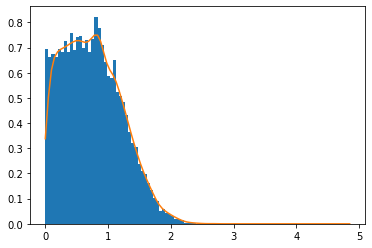

Histogram for F Test feature  2


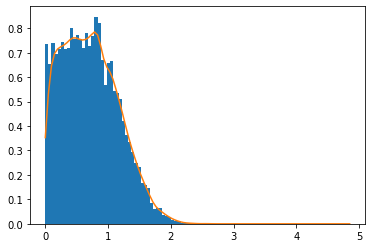

Histogram for F Test feature  3


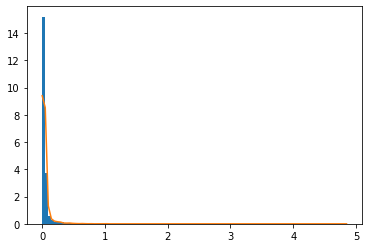

Histogram for F Test feature  4


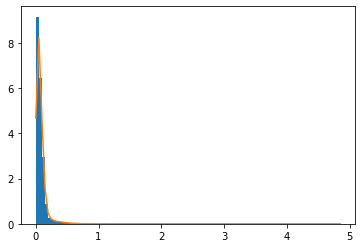

Histogram for F Test feature  5


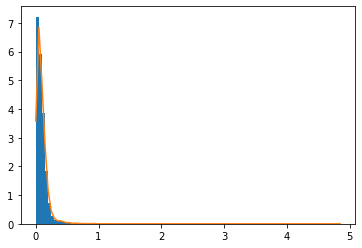

Histogram for F Test feature  6


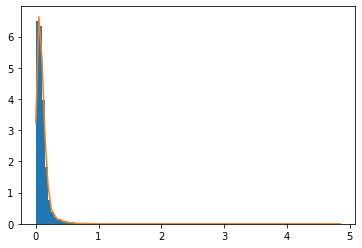

Histogram for F Test feature  7


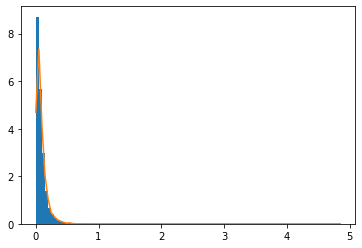

Histogram for F Test feature  8


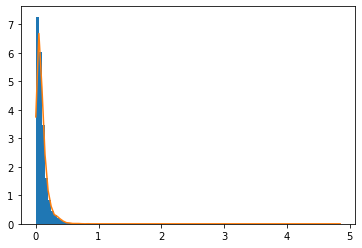

Histogram for F Test feature  9


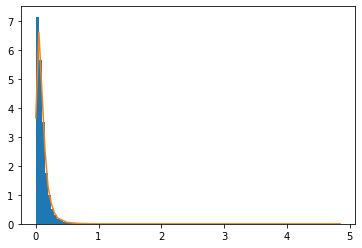

Histogram for F Test feature  10


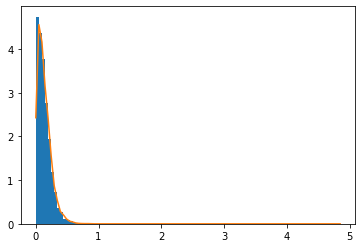

Histogram for F Test feature  11


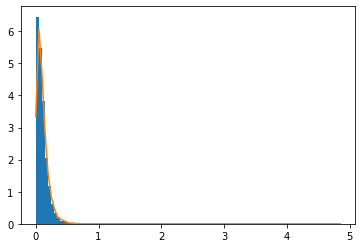

Histogram for F Test feature  12


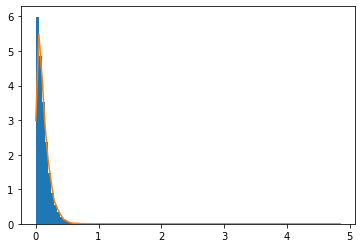

Histogram for F Test feature  13


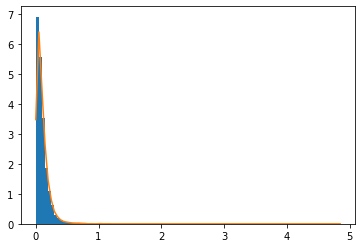

Histogram for F Test feature  14


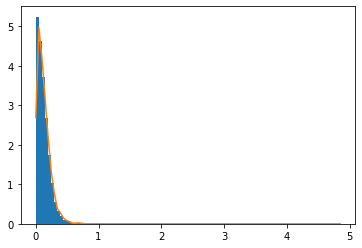

Histogram for F Test feature  15


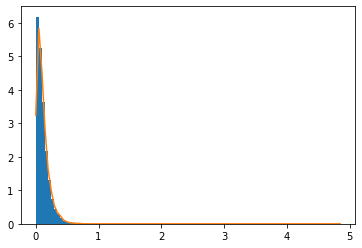

Histogram for F Test feature  16


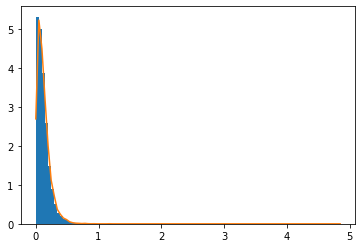

Histogram for F Test feature  17


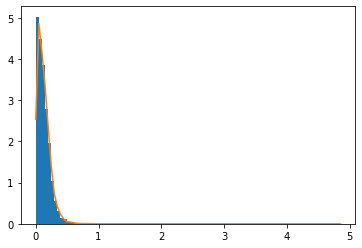

Histogram for F Test feature  18


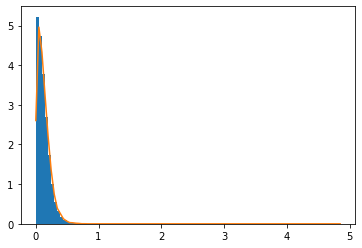

Histogram for F Test feature  19


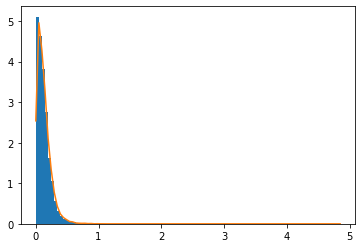

Histogram for F Test feature  20


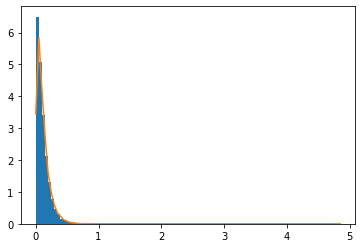

Histogram for F Test feature  21


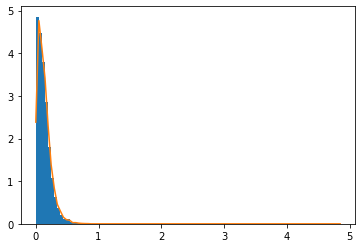

Histogram for F Test feature  22


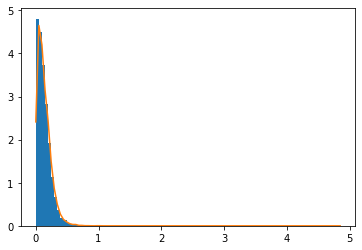

Histogram for F Test feature  23


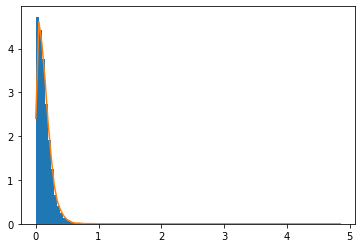

Histogram for F Test feature  24


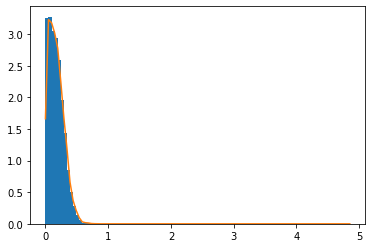

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2845
LR Accuracy on test data - All features:  0.1519
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2786
Logistic Regression Accuracy on test data - contrasted:  0.1602
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2839
Logistic Regression Accuracy on test data - contrasted:  0.1521
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2827
Logistic Regression Accuracy on test data - contrasted:  0.1512
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2843
Logistic Regression Accuracy on test data - contrasted:  0.1523
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2821
Logistic Regression Accuracy on test data - contrasted:  0.1534
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2819
Logistic Regression Accuracy on test data - contrasted:  0.1511
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2807
Logistic Regression Accuracy on test data - contrasted:  0.1547
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2803
Logistic Regression Accuracy on test data - contrasted:  0.1505
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.282
Logistic Regression Accuracy on test data - contrasted:  0.1526
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.278
Logistic Regression Accuracy on test data - contrasted:  0.148
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2815
Logistic Regression Accuracy on test data - contrasted:  0.1514
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2796
Logistic Regression Accuracy on test data - contrasted:  0.1522
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2829
Logistic Regression Accuracy on test data - contrasted:  0.1516
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2775
Logistic Regression Accuracy on test data - contrasted:  0.1489
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2775
Logistic Regression Accuracy on test data - contrasted:  0.1521
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2771
Logistic Regression Accuracy on test data - contrasted:  0.1481
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2809
Logistic Regression Accuracy on test data - contrasted:  0.153
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2814
Logistic Regression Accuracy on test data - contrasted:  0.1502
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2827
Logistic Regression Accuracy on test data - contrasted:  0.1527
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2816
Logistic Regression Accuracy on test data - contrasted:  0.152
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2801
Logistic Regression Accuracy on test data - contrasted:  0.146
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.281
Logistic Regression Accuracy on test data - contrasted:  0.1493
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2747
Logistic Regression Accuracy on test data - contrasted:  0.1505
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2822
Logistic Regression Accuracy on test data - contrasted:  0.1477
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2755
Logistic Regression Accuracy on test data - contrasted:  0.1476




Results for lamda  1000

Printing eigenvalues
(512,)
[1.31720987e-06 1.02709148e+00 5.35312691e+00 6.41602503e+00
 6.95633879e+00 1.05161577e+01 1.08999976e+01 1.13594016e+01
 1.16216636e+01 1.19139355e+01 1.24077059e+01 1.32181059e+01
 1.43362907e+01 1.45591112e+01 1.49901779e+01 1.51197446e+01
 1.54219188e+01 1.57092714e+01 1.60172479e+01 1.64318893e+01
 1.67240109e+01 1.71913715e+01 1.72824610e+01 1.78140223e+01
 1.81838214e+01 1.83905589e+01 1.88695271e+01 1.90643924e+01
 1.92634903e+01 1.95451594e+01 1.98689650e+01 2.00597686e+01
 2.02491217e+01 2.03852320e+01 2.06997045e+01 2.07759581e+01
 2.10179054e+01 2.12057944e+01 2.12487036e+01 2.13849761e+01
 2.16443556e+01 2.18507275e+01 2.22283315e+01 2.23072035e+01
 2.25850603e+01 2.27782564e+01 2.29784238e+01 2.33094802e+01
 2.35680258e+01 2.36779398e+01 2.38696140e+01 2.40082357e+01
 2.4195386

(512, 512)

array([[ 5.03668899e-02, -6.34208041e-04,  2.51356382e-03, ...,
        -4.52770992e-03,  1.05207697e-02,  3.30911475e-02],
       [-4.32631035e-02,  1.43668870e-03,  1.04710013e-03, ...,
         1.63960118e-01,  7.85183728e-02,  6.17030059e-02],
       [ 3.40565679e-02, -1.72262703e-03, -4.70399977e-03, ...,
         3.44001137e-02,  2.02166006e-02,  2.46242636e-02],
       ...,
       [ 1.85172372e-02,  2.02580197e-04, -4.62673789e-04, ...,
         1.44761740e-02,  3.59514091e-02,  1.08882452e-01],
       [-1.03639621e-01, -4.61128578e-04, -4.29181077e-04, ...,
         1.96647188e-02,  2.13092072e-02,  2.53368235e-02],
       [-2.05639009e-02,  1.68480438e-02,  3.21202251e-06, ...,
        -1.24838296e-02,  4.02179457e-03,  1.25385893e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[1.31720987e-06 1.02709148e+00 5.35312691e+00 6.41602503e+00
 6.95633879e+00 1.05161577e+01 1.08999976e+01 1.13594016e+01
 1.16216636e+01 1.19139355e+01 1.24077059e+01 1.32181059e+01
 1.43362907e+01 1.45591112e+01 1.49901779e+01 1.51197446e+01
 1.54219188e+01 1.57092714e+01 1.60172479e+01 1.64318893e+01
 1.67240109e+01 1.71913715e+01 1.72824610e+01 1.78140223e+01
 1.81838214e+01]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[1.31720987e-06 1.02709148e+00 5.35312691e+00 6.41602503e+00
 6.95633879e+00 1.05161577e+01 1.08999976e+01 1.13594016e+01
 1.16216636e+01 1.19139355e+01 1.24077059e+01 1.32181059e+01
 1.43362907e+01 1.45591112e+01 1.49901779e+01 1.51197446e+01
 1.54219188e+01 1.57092714e+01 1.60172479e+01 1.64318893e+01
 1.67240109e+01 1.71913715e+01 1.72824610e+01 1.78140223e+01]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,276151.287951,276154.309922,0.022879,0.093987,0.068552,0.025528,0.014063,0.015818,0.101800,0.059169,...,0.146623,0.187347,0.045505,0.022269,0.012295,0.016200,0.043563,0.038244,0.022578,0.137156
1,150523.862493,150527.062508,0.013149,0.015478,0.043012,0.047290,0.029921,0.037755,0.004135,0.029473,...,0.273445,0.102200,0.150042,0.078612,0.001996,0.183199,0.044945,0.289851,0.214894,0.194217
2,25786.033894,25789.228631,0.003881,0.000481,0.024474,0.020327,0.015208,0.050395,0.055086,0.044954,...,0.206330,0.023827,0.020977,0.094687,0.135733,0.034173,0.075103,0.062569,0.171138,0.087199
3,95781.489136,95783.186984,0.007122,0.051931,0.007275,0.026407,0.066342,0.072206,0.040867,0.099541,...,0.081200,0.089543,0.023492,0.054297,0.004134,0.309558,0.292387,0.094463,0.007011,0.052463
4,299359.227923,299357.636247,0.046238,0.000286,0.042495,0.018107,0.189645,0.185040,0.091903,0.056712,...,0.216951,0.122500,0.271005,0.106227,0.085633,0.139930,0.070159,0.043743,0.100997,0.283131


Histogram for F Test feature  0


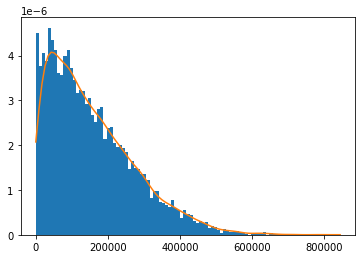

Histogram for F Test feature  1


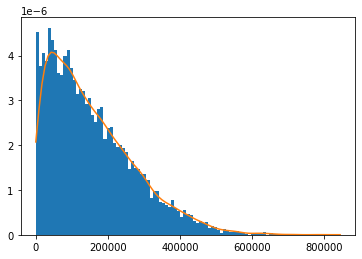

Histogram for F Test feature  2


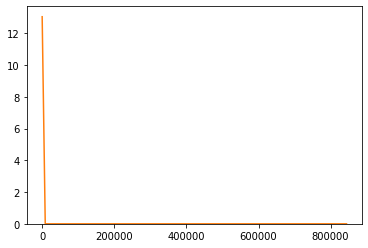

Histogram for F Test feature  3


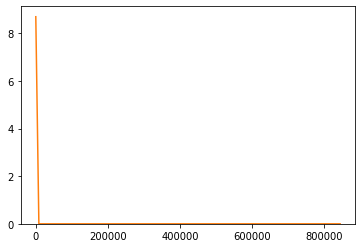

Histogram for F Test feature  4


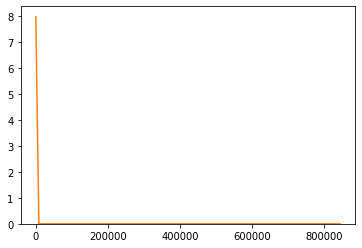

Histogram for F Test feature  5


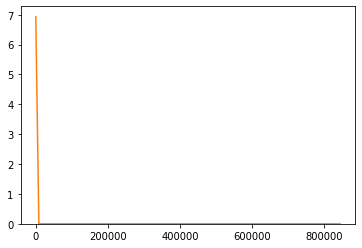

Histogram for F Test feature  6


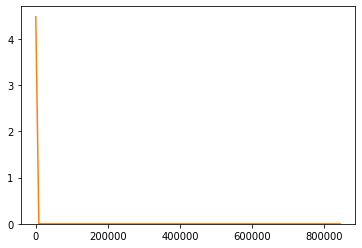

Histogram for F Test feature  7


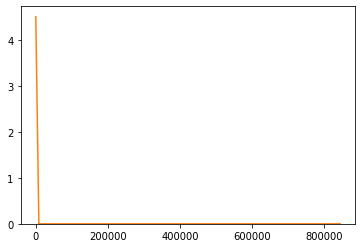

Histogram for F Test feature  8


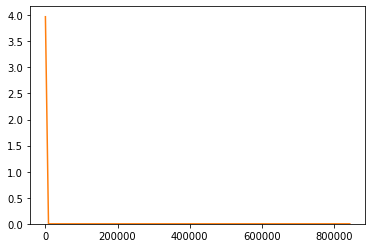

Histogram for F Test feature  9


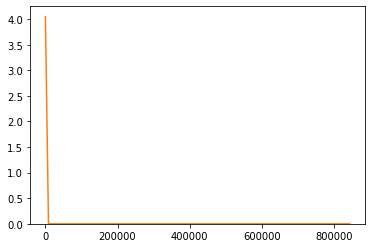

Histogram for F Test feature  10


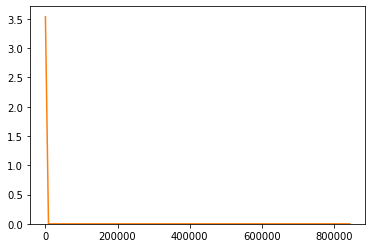

Histogram for F Test feature  11


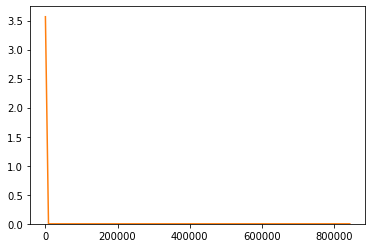

Histogram for F Test feature  12


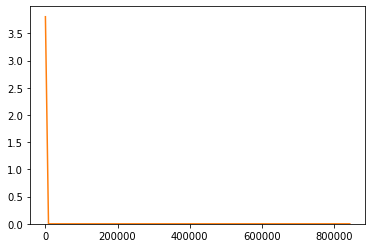

Histogram for F Test feature  13


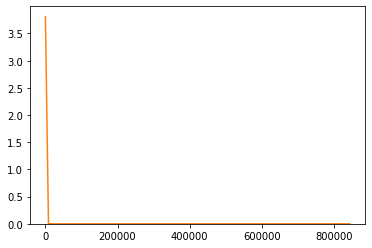

Histogram for F Test feature  14


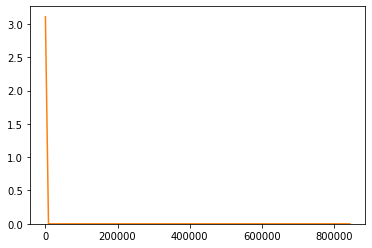

Histogram for F Test feature  15


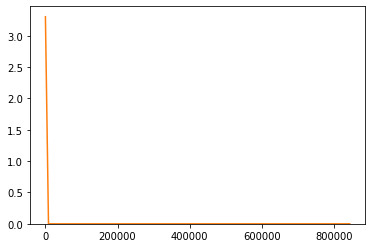

Histogram for F Test feature  16


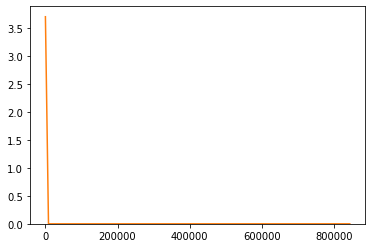

Histogram for F Test feature  17


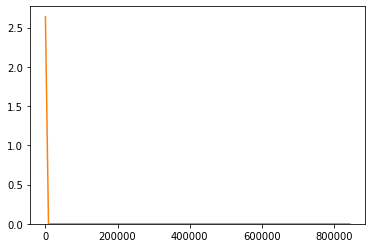

Histogram for F Test feature  18


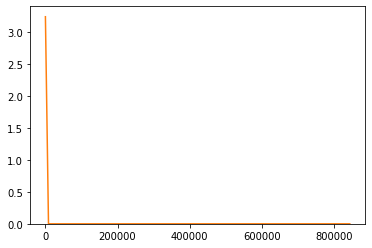

Histogram for F Test feature  19


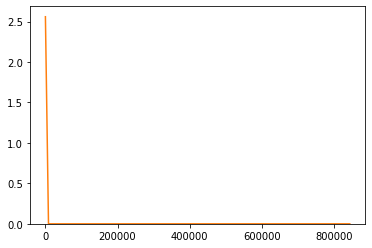

Histogram for F Test feature  20


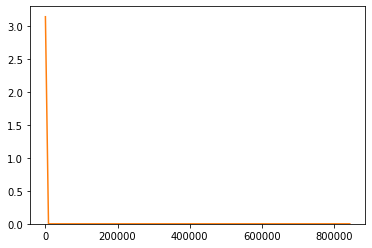

Histogram for F Test feature  21


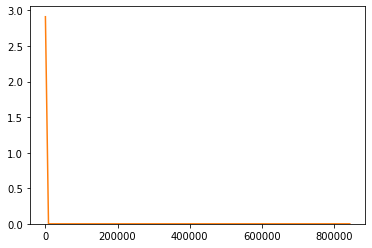

Histogram for F Test feature  22


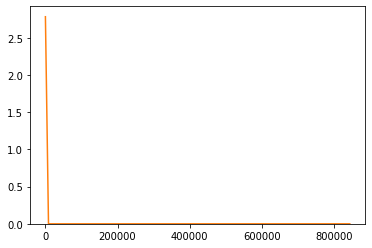

Histogram for F Test feature  23


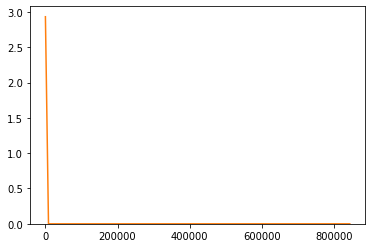

Histogram for F Test feature  24


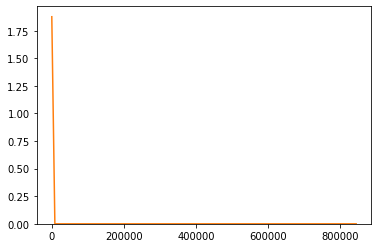

LR Accuracy within training data - All features :  0.1375
LR Accuracy on test data - All features:  0.1245
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not contrasted:  0.1375
Logistic Regression Accuracy on test data - contrasted:  0.1245
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not contrasted:  0.1375
Logistic Regression Accuracy on test data - contrasted:  0.1245
Accuracy for without feature  2
Logistic Regression Accuracy within training data - not contrasted:  0.1375
Logistic Regression Accuracy on test data - contrasted:  0.1245
Accuracy for without feature  3
Logistic Regression Accuracy within training data - not contrasted:  0.1375
Logistic Regression Accuracy on test data - contrasted:  0.1245
Accuracy for without feature  4
Logistic Regression Accuracy within training data - not contrasted:  0.1375
Logistic Regression Accuracy on test data - contrasted:  0.1245
Accuracy for without feature  5
L

(512, 512)

array([[ 5.03668500e-02, -6.40527866e-04,  2.52712265e-03, ...,
        -4.54099357e-03,  1.05185690e-02,  3.30979040e-02],
       [-4.32632178e-02,  1.43523326e-03,  1.04917398e-03, ...,
         1.64009140e-01,  7.86045937e-02,  6.17153935e-02],
       [ 3.40564808e-02, -1.71718599e-03, -4.72289793e-03, ...,
         3.44146660e-02,  2.02402024e-02,  2.46250174e-02],
       ...,
       [ 1.85172479e-02,  1.96768527e-04, -4.56423735e-04, ...,
         1.44798120e-02,  3.59497746e-02,  1.08857262e-01],
       [-1.03639624e-01, -4.57226798e-04, -4.19085681e-04, ...,
         1.97183853e-02,  2.13276646e-02,  2.53517355e-02],
       [-2.05638856e-02,  1.68478106e-02,  2.10204476e-05, ...,
        -1.24881071e-02,  4.02361511e-03,  1.25329469e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[  0.          10.27644046  53.59380516  64.21219425  69.61510829
 105.23803303 109.09039666 113.70838165 116.3330219  119.28782116
 124.17951497 132.29179706 143.50724298 145.73212057 150.01801719
 151.32021907 154.3530225  157.22312293 160.33358703 164.47019831
 167.37928043 172.06632563 172.97162114 178.33855725 181.99235579]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 10.27644046  53.59380516  64.21219425  69.61510829 105.23803303
 109.09039666 113.70838165 116.3330219  119.28782116 124.17951497
 132.29179706 143.50724298 145.73212057 150.01801719 151.32021907
 154.3530225  157.22312293 160.33358703 164.47019831 167.37928043
 172.06632563 172.97162114 178.33855725 181.99235579]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.018187,0.072705,0.071762,0.011065,0.023647,0.044270,0.131753,0.049324,0.066058,...,0.158835,0.034794,0.011457,0.003069,0.094665,0.032379,0.045231,0.003992,0.145689,0.078576
1,3.200015,0.035405,0.003715,0.041606,0.038959,0.009325,0.022377,0.011508,0.025414,0.060780,...,0.086561,0.144462,0.097035,0.003125,0.141627,0.036521,0.293021,0.204391,0.193165,0.090156
2,3.194737,0.007478,0.002052,0.023994,0.022921,0.017713,0.048585,0.056647,0.044105,0.048662,...,0.026334,0.016253,0.097841,0.130534,0.028614,0.070067,0.059343,0.168412,0.080947,0.058974
3,1.697847,0.007164,0.044394,0.008228,0.021684,0.053540,0.061531,0.031224,0.102383,0.011886,...,0.099072,0.019812,0.065464,0.000822,0.282503,0.287557,0.095613,0.013529,0.050140,0.074147
4,1.591675,0.001157,0.021977,0.047206,0.006428,0.145813,0.149769,0.057985,0.041517,0.016465,...,0.091803,0.273983,0.070015,0.087610,0.050942,0.068882,0.045938,0.116356,0.254826,0.026347


Histogram for F Test feature  0


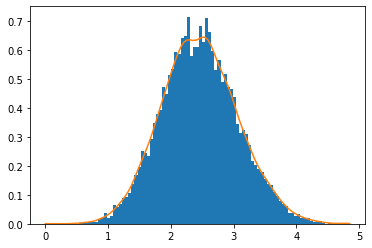

Histogram for F Test feature  1


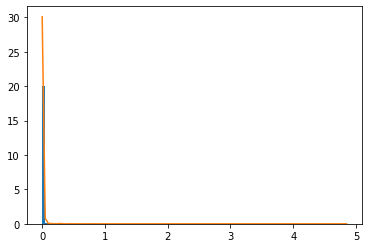

Histogram for F Test feature  2


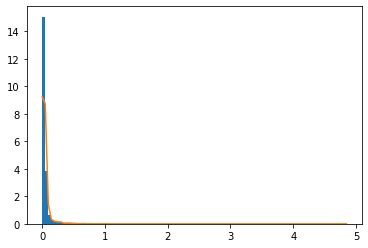

Histogram for F Test feature  3


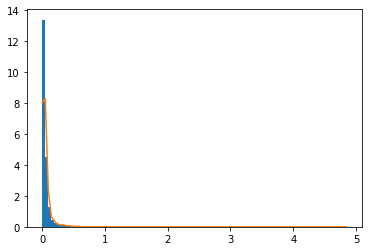

Histogram for F Test feature  4


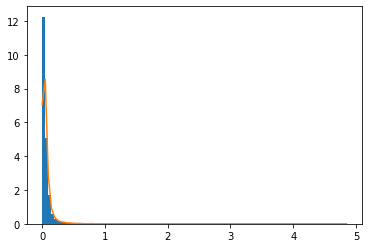

Histogram for F Test feature  5


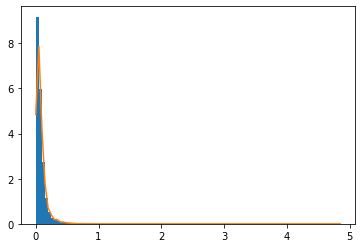

Histogram for F Test feature  6


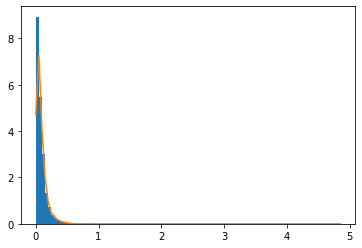

Histogram for F Test feature  7


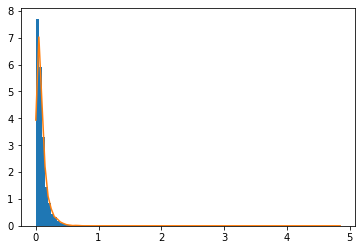

Histogram for F Test feature  8


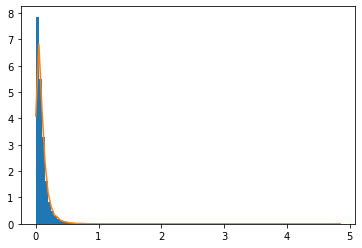

Histogram for F Test feature  9


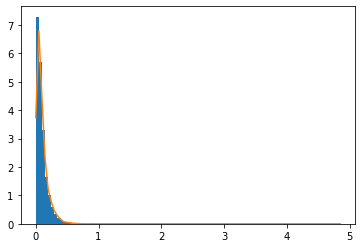

Histogram for F Test feature  10


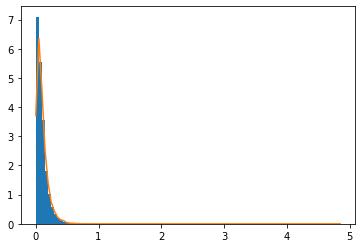

Histogram for F Test feature  11


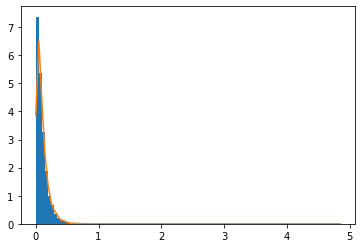

Histogram for F Test feature  12


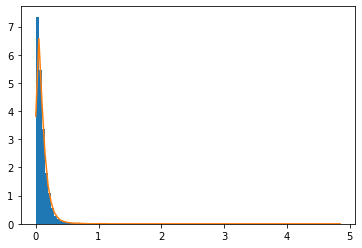

Histogram for F Test feature  13


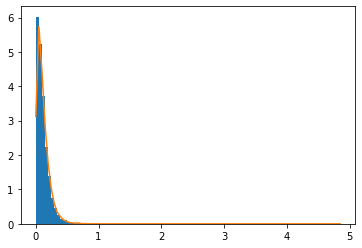

Histogram for F Test feature  14


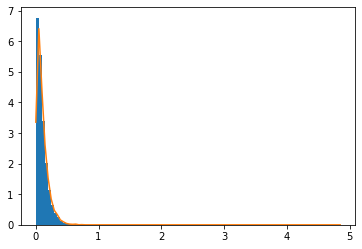

Histogram for F Test feature  15


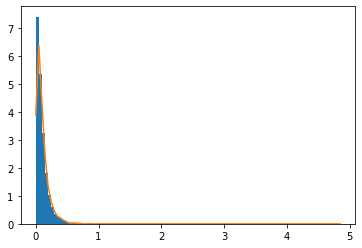

Histogram for F Test feature  16


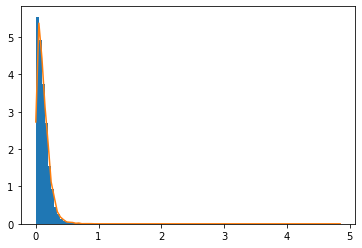

Histogram for F Test feature  17


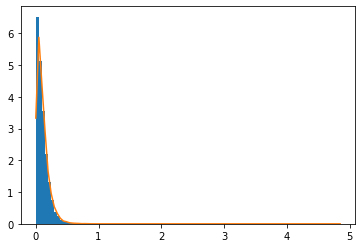

Histogram for F Test feature  18


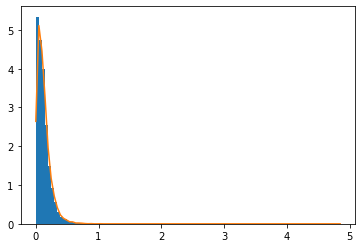

Histogram for F Test feature  19


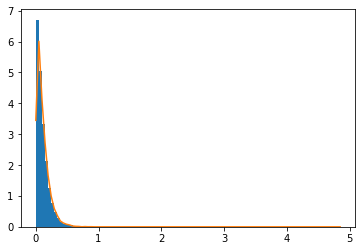

Histogram for F Test feature  20


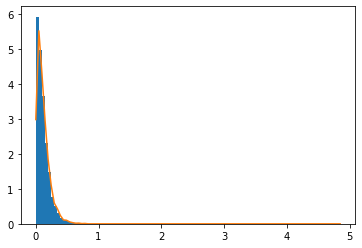

Histogram for F Test feature  21


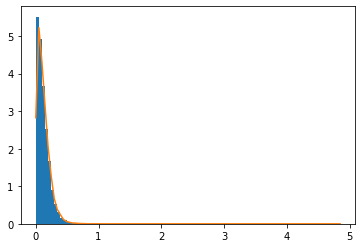

Histogram for F Test feature  22


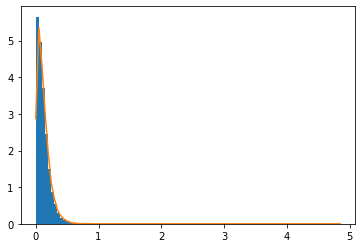

Histogram for F Test feature  23


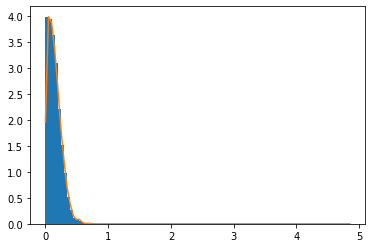

Histogram for F Test feature  24


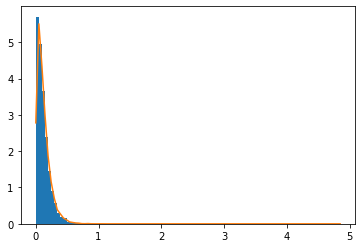

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2463
LR Accuracy on test data - All features:  0.136
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not contrasted:  0.2371
Logistic Regression Accuracy on test data - contrasted:  0.1621
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not contrasted:  0.243
Logistic Regression Accuracy on test data - contrasted:  0.1354
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.1353
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2468
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2461
Logistic Regression Accuracy on test data - contrasted:  0.135
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2444
Logistic Regression Accuracy on test data - contrasted:  0.1392
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2422
Logistic Regression Accuracy on test data - contrasted:  0.136
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.137
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2368
Logistic Regression Accuracy on test data - contrasted:  0.1331
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2389
Logistic Regression Accuracy on test data - contrasted:  0.1385
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1363
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.244
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2437
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.1343
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2411
Logistic Regression Accuracy on test data - contrasted:  0.1338
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2429
Logistic Regression Accuracy on test data - contrasted:  0.1373
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2423
Logistic Regression Accuracy on test data - contrasted:  0.1334
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2417
Logistic Regression Accuracy on test data - contrasted:  0.1347
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1281
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2447
Logistic Regression Accuracy on test data - contrasted:  0.1331
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2401
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2425
Logistic Regression Accuracy on test data - contrasted:  0.1344
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2404
Logistic Regression Accuracy on test data - contrasted:  0.137
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1416




Results for lamda  100000

Printing eigenvalues
(512,)
[1.05059068e-10 1.02769923e+02 5.36000711e+02 6.42173781e+02
 6.96202254e+02 1.05245611e+03 1.09099442e+03 1.13719801e+03
 1.16344624e+03 1.19302357e+03 1.24189798e+03 1.32302823e+03
 1.43521630e+03 1.45746140e+03 1.50029549e+03 1.51332360e+03
 1.54366341e+03 1.57236110e+03 1.60349436e+03 1.64485282e+03
 1.67392995e+03 1.72081534e+03 1.72986251e+03 1.78357723e+03
 1.82007652e+03 1.84097403e+03 1.88874566e+03 1.90854169e+03
 1.92823091e+03 1.95655202e+03 1.98918556e+03 2.00832846e+03
 2.02732229e+03 2.04088876e+03 2.07223765e+03 2.07985470e+03
 2.10448682e+03 2.12309144e+03 2.12715559e+03 2.14091430e+03
 2.16682741e+03 2.18773073e+03 2.22493374e+03 2.23323911e+03
 2.26106737e+03 2.28021814e+03 2.30009806e+03 2.33383632e+03
 2.35988011e+03 2.37035471e+03 2.38928153e+03 2.40328965e+03
 2.42240

(512, 512)

array([[ 5.03668562e-02, -6.41125179e-04,  2.52844553e-03, ...,
        -4.54232772e-03,  1.05183476e-02,  3.30985792e-02],
       [-4.32631817e-02,  1.43508250e-03,  1.04929206e-03, ...,
         1.64014031e-01,  7.86132195e-02,  6.17166315e-02],
       [ 3.40565116e-02, -1.71668182e-03, -4.72477450e-03, ...,
         3.44161160e-02,  2.02425592e-02,  2.46250928e-02],
       ...,
       [ 1.85172463e-02,  1.96161213e-04, -4.55721918e-04, ...,
         1.44801685e-02,  3.59496189e-02,  1.08854742e-01],
       [-1.03639633e-01, -4.56818175e-04, -4.18136581e-04, ...,
         1.97237464e-02,  2.13295127e-02,  2.53532254e-02],
       [-2.05639415e-02,  1.68478106e-02,  2.26276363e-05, ...,
        -1.24885375e-02,  4.02379734e-03,  1.25323830e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          102.7699233   536.00071138  642.17378096  696.20225418
 1052.45611337 1090.99441886 1137.19801417 1163.44624399 1193.02357419
 1241.89798004 1323.02823056 1435.21629942 1457.4614031  1500.29549026
 1513.32360339 1543.66341429 1572.36109974 1603.4943587  1644.85281699
 1673.92994631 1720.81533533 1729.86251187 1783.57723404 1820.07652282]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 102.7699233   536.00071138  642.17378096  696.20225418 1052.45611337
 1090.99441886 1137.19801417 1163.44624399 1193.02357419 1241.89798004
 1323.02823056 1435.21629942 1457.4614031  1500.29549026 1513.32360339
 1543.66341429 1572.36109974 1603.4943587  1644.85281699 1673.92994631
 1720.81533533 1729.86251187 1783.57723404 1820.07652282]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.018143,0.072643,0.071699,0.010859,0.023564,0.044059,0.131678,0.049527,0.065724,...,0.158938,0.034352,0.011510,0.002438,0.094494,0.031884,0.045663,0.003843,0.144654,0.078428
1,3.200015,0.035369,0.003667,0.041672,0.038807,0.009367,0.022501,0.011403,0.025644,0.060533,...,0.086607,0.144250,0.097073,0.003468,0.141837,0.036036,0.293186,0.204276,0.194050,0.090168
2,3.194737,0.007453,0.002109,0.023917,0.023052,0.017608,0.048680,0.056524,0.043922,0.048861,...,0.026315,0.015869,0.097837,0.130086,0.028786,0.069654,0.059068,0.168303,0.080209,0.059033
3,1.697847,0.007152,0.044357,0.008190,0.021641,0.053596,0.061523,0.031322,0.102258,0.011838,...,0.099005,0.019664,0.065433,0.000596,0.282573,0.287298,0.095636,0.013594,0.050562,0.074128
4,1.591675,0.001154,0.021914,0.047247,0.006570,0.145619,0.149581,0.057937,0.041318,0.016280,...,0.091953,0.273661,0.069976,0.088019,0.050777,0.069341,0.046372,0.116054,0.254211,0.026426


Histogram for F Test feature  0


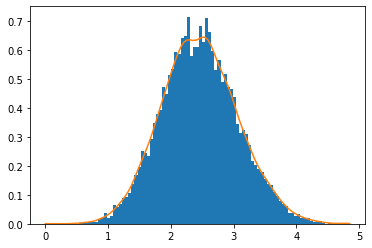

Histogram for F Test feature  1


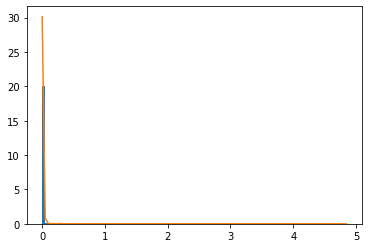

Histogram for F Test feature  2


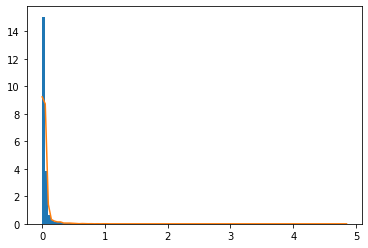

Histogram for F Test feature  3


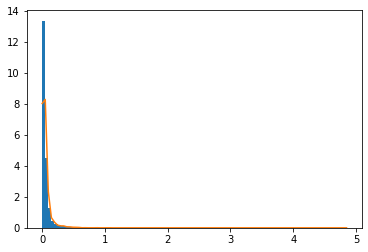

Histogram for F Test feature  4


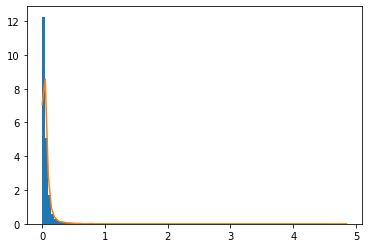

Histogram for F Test feature  5


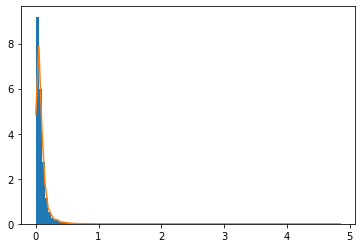

Histogram for F Test feature  6


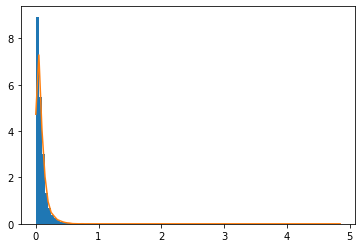

Histogram for F Test feature  7


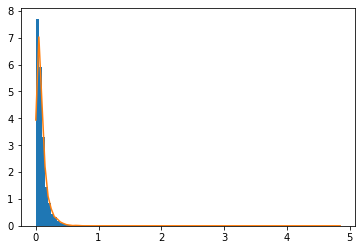

Histogram for F Test feature  8


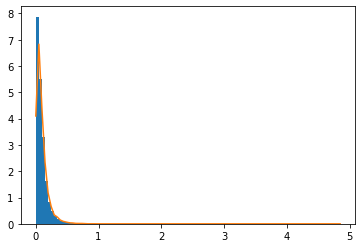

Histogram for F Test feature  9


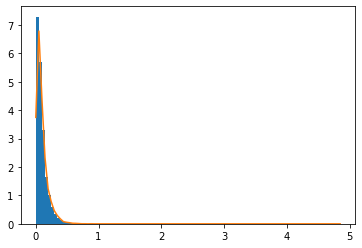

Histogram for F Test feature  10


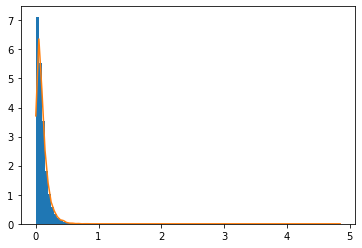

Histogram for F Test feature  11


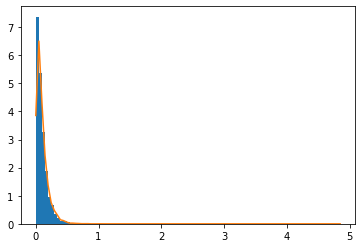

Histogram for F Test feature  12


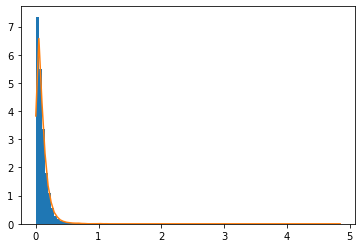

Histogram for F Test feature  13


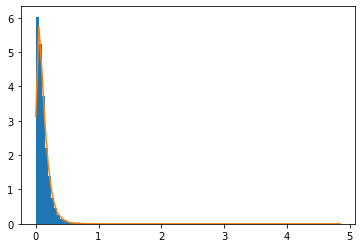

Histogram for F Test feature  14


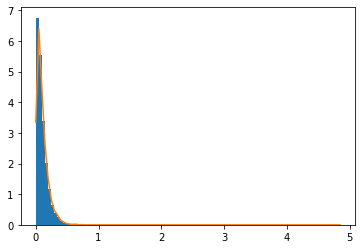

Histogram for F Test feature  15


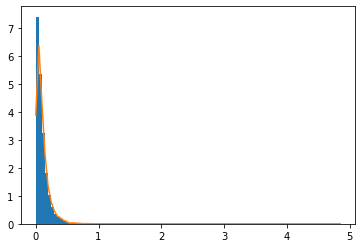

Histogram for F Test feature  16


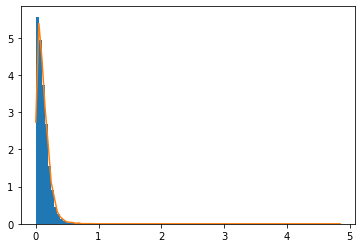

Histogram for F Test feature  17


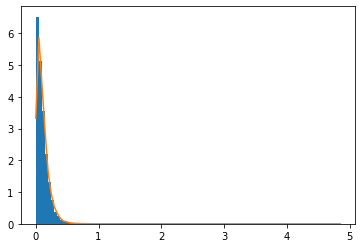

Histogram for F Test feature  18


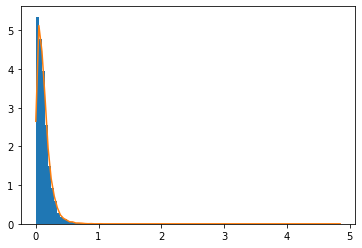

Histogram for F Test feature  19


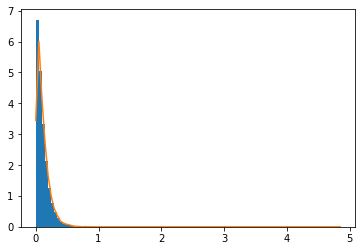

Histogram for F Test feature  20


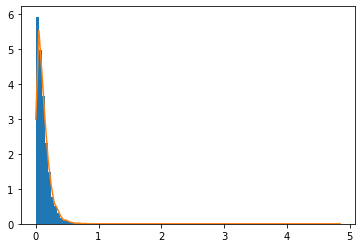

Histogram for F Test feature  21


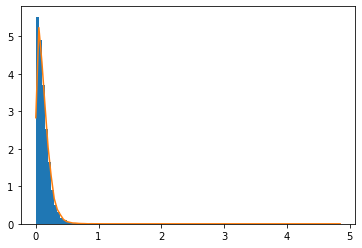

Histogram for F Test feature  22


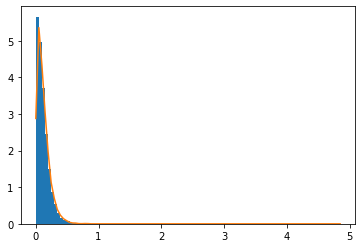

Histogram for F Test feature  23


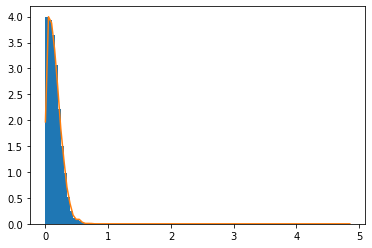

Histogram for F Test feature  24


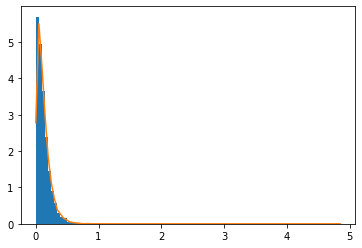

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2459
LR Accuracy on test data - All features:  0.136
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not contrasted:  0.2369
Logistic Regression Accuracy on test data - contrasted:  0.1622
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2425
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.1354
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2462
Logistic Regression Accuracy on test data - contrasted:  0.1358
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2452
Logistic Regression Accuracy on test data - contrasted:  0.135
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2439
Logistic Regression Accuracy on test data - contrasted:  0.1384
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2422
Logistic Regression Accuracy on test data - contrasted:  0.1356
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2407
Logistic Regression Accuracy on test data - contrasted:  0.1369
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2357
Logistic Regression Accuracy on test data - contrasted:  0.1327
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2393
Logistic Regression Accuracy on test data - contrasted:  0.1381
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2412
Logistic Regression Accuracy on test data - contrasted:  0.1367
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.136
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.243
Logistic Regression Accuracy on test data - contrasted:  0.1358
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2396
Logistic Regression Accuracy on test data - contrasted:  0.1347
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2408
Logistic Regression Accuracy on test data - contrasted:  0.1338
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2424
Logistic Regression Accuracy on test data - contrasted:  0.1368
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2427
Logistic Regression Accuracy on test data - contrasted:  0.1335
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1367
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2407
Logistic Regression Accuracy on test data - contrasted:  0.1345
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1279
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2445
Logistic Regression Accuracy on test data - contrasted:  0.1324
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2392
Logistic Regression Accuracy on test data - contrasted:  0.1356
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2426
Logistic Regression Accuracy on test data - contrasted:  0.1343
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.24
Logistic Regression Accuracy on test data - contrasted:  0.1373
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.1419




Results for lamda  10000

Printing eigenvalues
(512,)
[-7.63206285e-07  1.02764405e+01  5.35938052e+01  6.42121942e+01
  6.96151083e+01  1.05238033e+02  1.09090397e+02  1.13708382e+02
  1.16333022e+02  1.19287821e+02  1.24179515e+02  1.32291797e+02
  1.43507243e+02  1.45732121e+02  1.50018017e+02  1.51320219e+02
  1.54353023e+02  1.57223123e+02  1.60333587e+02  1.64470198e+02
  1.67379280e+02  1.72066326e+02  1.72971621e+02  1.78338557e+02
  1.81992356e+02  1.84080094e+02  1.88858436e+02  1.90835205e+02
  1.92806194e+02  1.95636701e+02  1.98897834e+02  2.00811624e+02
  2.02710642e+02  2.04067640e+02  2.07203291e+02  2.07965083e+02
  2.10424415e+02  2.12286475e+02  2.12694936e+02  2.14069655e+02
  2.16661089e+02  2.18749029e+02  2.22474263e+02  2.23301170e+02
  2.26083648e+02  2.28000044e+02  2.29989414e+02  2.33357653e+02
  2.35960133e+02  2.370

(512, 512)

array([[ 5.03668500e-02, -6.40527866e-04,  2.52712265e-03, ...,
        -4.54099357e-03,  1.05185690e-02,  3.30979040e-02],
       [-4.32632178e-02,  1.43523326e-03,  1.04917398e-03, ...,
         1.64009140e-01,  7.86045937e-02,  6.17153935e-02],
       [ 3.40564808e-02, -1.71718599e-03, -4.72289793e-03, ...,
         3.44146660e-02,  2.02402024e-02,  2.46250174e-02],
       ...,
       [ 1.85172479e-02,  1.96768527e-04, -4.56423735e-04, ...,
         1.44798120e-02,  3.59497746e-02,  1.08857262e-01],
       [-1.03639624e-01, -4.57226798e-04, -4.19085681e-04, ...,
         1.97183853e-02,  2.13276646e-02,  2.53517355e-02],
       [-2.05638856e-02,  1.68478106e-02,  2.10204476e-05, ...,
        -1.24881071e-02,  4.02361511e-03,  1.25329469e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[  0.          10.27644046  53.59380516  64.21219425  69.61510829
 105.23803303 109.09039666 113.70838165 116.3330219  119.28782116
 124.17951497 132.29179706 143.50724298 145.73212057 150.01801719
 151.32021907 154.3530225  157.22312293 160.33358703 164.47019831
 167.37928043 172.06632563 172.97162114 178.33855725 181.99235579]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 10.27644046  53.59380516  64.21219425  69.61510829 105.23803303
 109.09039666 113.70838165 116.3330219  119.28782116 124.17951497
 132.29179706 143.50724298 145.73212057 150.01801719 151.32021907
 154.3530225  157.22312293 160.33358703 164.47019831 167.37928043
 172.06632563 172.97162114 178.33855725 181.99235579]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.018187,0.072705,0.071762,0.011065,0.023647,0.044270,0.131753,0.049324,0.066058,...,0.158835,0.034794,0.011457,0.003069,0.094665,0.032379,0.045231,0.003992,0.145689,0.078576
1,3.200015,0.035405,0.003715,0.041606,0.038959,0.009325,0.022377,0.011508,0.025414,0.060780,...,0.086561,0.144462,0.097035,0.003125,0.141627,0.036521,0.293021,0.204391,0.193165,0.090156
2,3.194737,0.007478,0.002052,0.023994,0.022921,0.017713,0.048585,0.056647,0.044105,0.048662,...,0.026334,0.016253,0.097841,0.130534,0.028614,0.070067,0.059343,0.168412,0.080947,0.058974
3,1.697847,0.007164,0.044394,0.008228,0.021684,0.053540,0.061531,0.031224,0.102383,0.011886,...,0.099072,0.019812,0.065464,0.000822,0.282503,0.287557,0.095613,0.013529,0.050140,0.074147
4,1.591675,0.001157,0.021977,0.047206,0.006428,0.145813,0.149769,0.057985,0.041517,0.016465,...,0.091803,0.273983,0.070015,0.087610,0.050942,0.068882,0.045938,0.116356,0.254826,0.026347


Histogram for F Test feature  0


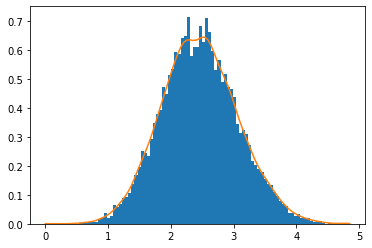

Histogram for F Test feature  1


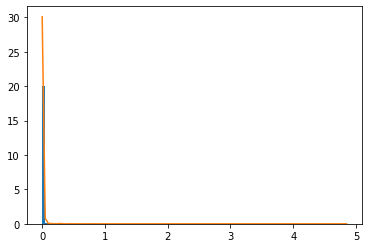

Histogram for F Test feature  2


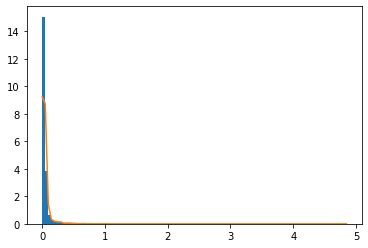

Histogram for F Test feature  3


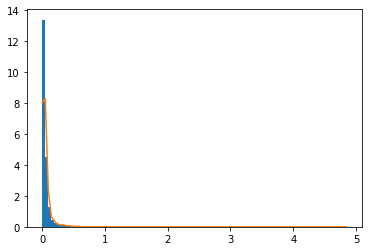

Histogram for F Test feature  4


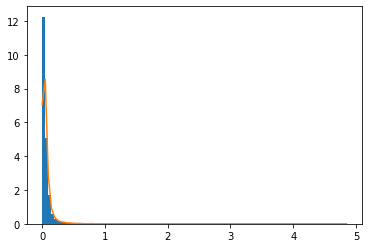

Histogram for F Test feature  5


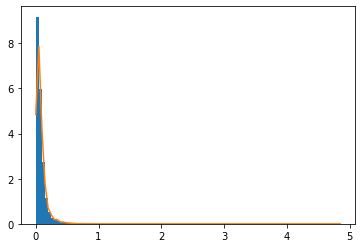

Histogram for F Test feature  6


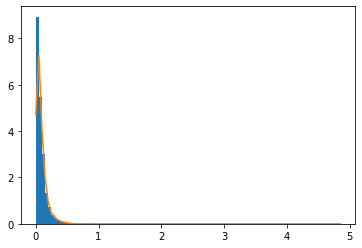

Histogram for F Test feature  7


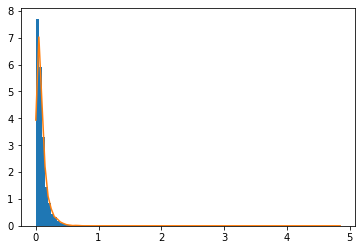

Histogram for F Test feature  8


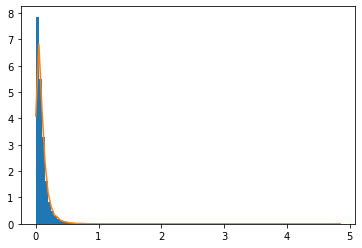

Histogram for F Test feature  9


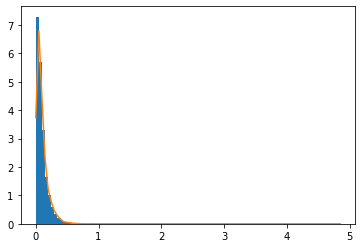

Histogram for F Test feature  10


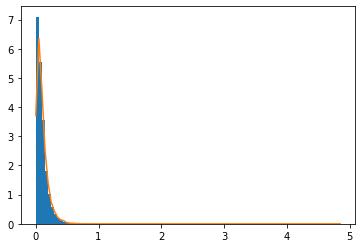

Histogram for F Test feature  11


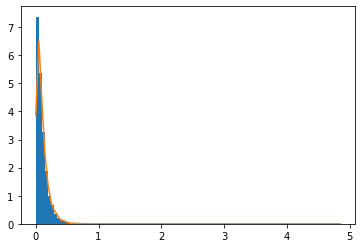

Histogram for F Test feature  12


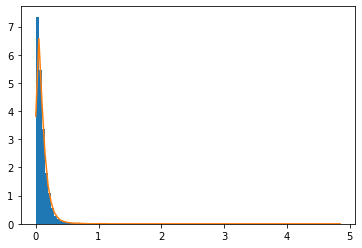

Histogram for F Test feature  13


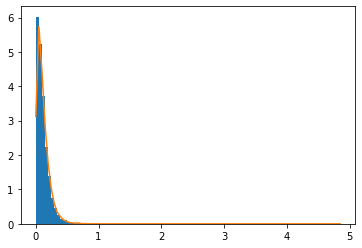

Histogram for F Test feature  14


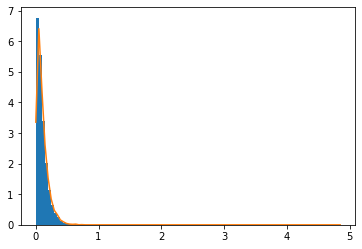

Histogram for F Test feature  15


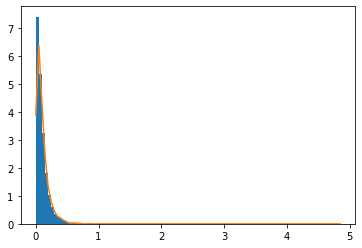

Histogram for F Test feature  16


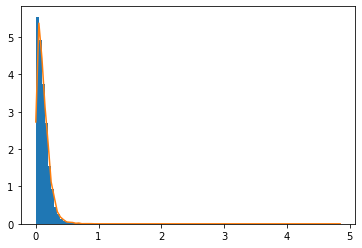

Histogram for F Test feature  17


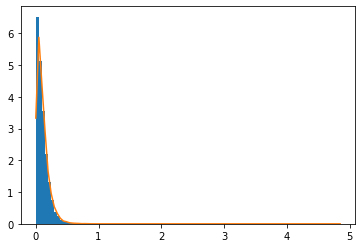

Histogram for F Test feature  18


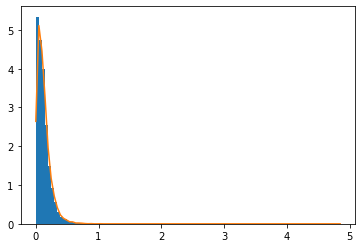

Histogram for F Test feature  19


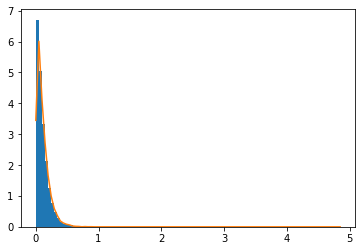

Histogram for F Test feature  20


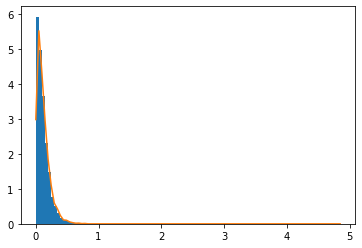

Histogram for F Test feature  21


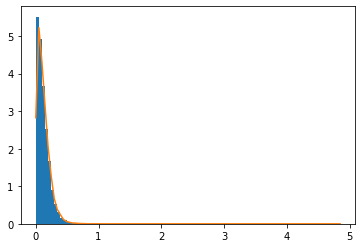

Histogram for F Test feature  22


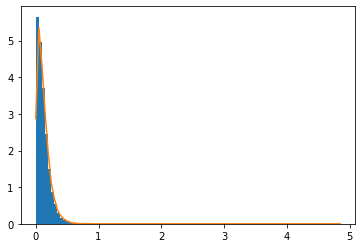

Histogram for F Test feature  23


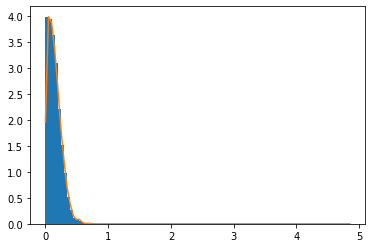

Histogram for F Test feature  24


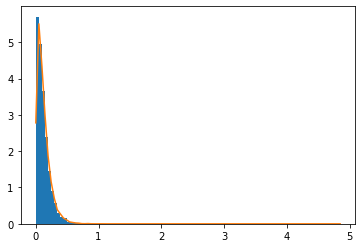

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2463
LR Accuracy on test data - All features:  0.136
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not contrasted:  0.2371
Logistic Regression Accuracy on test data - contrasted:  0.1621
Accuracy for without feature  1
Logistic Regression Accuracy within training data - not contrasted:  0.243
Logistic Regression Accuracy on test data - contrasted:  0.1354
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.1353
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2468
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2461
Logistic Regression Accuracy on test data - contrasted:  0.135
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2444
Logistic Regression Accuracy on test data - contrasted:  0.1392
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2422
Logistic Regression Accuracy on test data - contrasted:  0.136
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.137
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2368
Logistic Regression Accuracy on test data - contrasted:  0.1331
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2389
Logistic Regression Accuracy on test data - contrasted:  0.1385
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1363
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.244
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2437
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.1343
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2411
Logistic Regression Accuracy on test data - contrasted:  0.1338
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2429
Logistic Regression Accuracy on test data - contrasted:  0.1373
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2423
Logistic Regression Accuracy on test data - contrasted:  0.1334
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1359
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2417
Logistic Regression Accuracy on test data - contrasted:  0.1347
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1281
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2447
Logistic Regression Accuracy on test data - contrasted:  0.1331
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2401
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2425
Logistic Regression Accuracy on test data - contrasted:  0.1344
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2404
Logistic Regression Accuracy on test data - contrasted:  0.137
Accuracy for without feature  24
Logistic Regression Accuracy within training data - not contrasted:  0.2414
Logistic Regression Accuracy on test data - contrasted:  0.1416


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [1,10,100,1000,10000,100000,10000]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.05) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_contrast_labels)/2),:] - Z[int(len(train_contrast_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = contrast_coefficients @ contrast_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    print("Printing eigenvalues")
    print(eigenvalues.shape)
    print(eigenvalues)
    print("Printing eigenvectors")
    display(eigenvectors.shape)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = contrast_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on contrasted images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    X_torch_train = F_test_original
    X_torch_test = F_test_contrasted
    X_torch_test_within = F_test_original

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))

    
    


    # Trained on original images, tested on contrasted images: Contrast Features removed from F_test

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_test_original.detach().numpy().copy()
        X_torch_test = F_test_contrasted.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)

        print('Logistic Regression Accuracy within training data - not contrasted: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - contrasted: ', logistic_regression_model.score(X_torch_test, targets_test))




